# Processing
George Brencher, some code from Zach Keskinen, Daniel Hogan 

-----------------------------------------------------

This notebook walks through the few steps needed to retrieve snow depth for a given date range and area of interest with spicy-snow. It can be applied for most land surfaces on earth with seasonal snow. First, install spicy-snow:

In [ ]:
# install spicy-snow in the current Jupyter kernel
import sys
!{sys.executable} -m pip install spicy-snow

In [1]:
# import spicy-snow functions and other required packages
# depending on your environment, you may need to install some of these
from spicy_snow.retrieval import retrieve_snow_depth
from spicy_snow.IO.user_dates import get_input_dates
from shapely import geometry
import json
import geopandas as gpd
# for optional plotting
import contextily as cx 
import matplotlib.pyplot as plt

Next, we need to define our area of interest. This can be done directly with a latitude and longitude range or with a geojson. In this case, we're using the geojson for the Upper East River Basin near Crested Butte in Colorado. 

In [2]:
# to use lat-lon range for aoi
#area = geometry.box(-113.2, 43, -113, 43.4)

# to use geojson for aoi
# geojson is expected to be in wgs84. 
area_gdf = gpd.read_file('./east_river_basin_wgs.geojson')
area = list(area_gdf.geometry)[0] # grab the first feature in the multipolygon

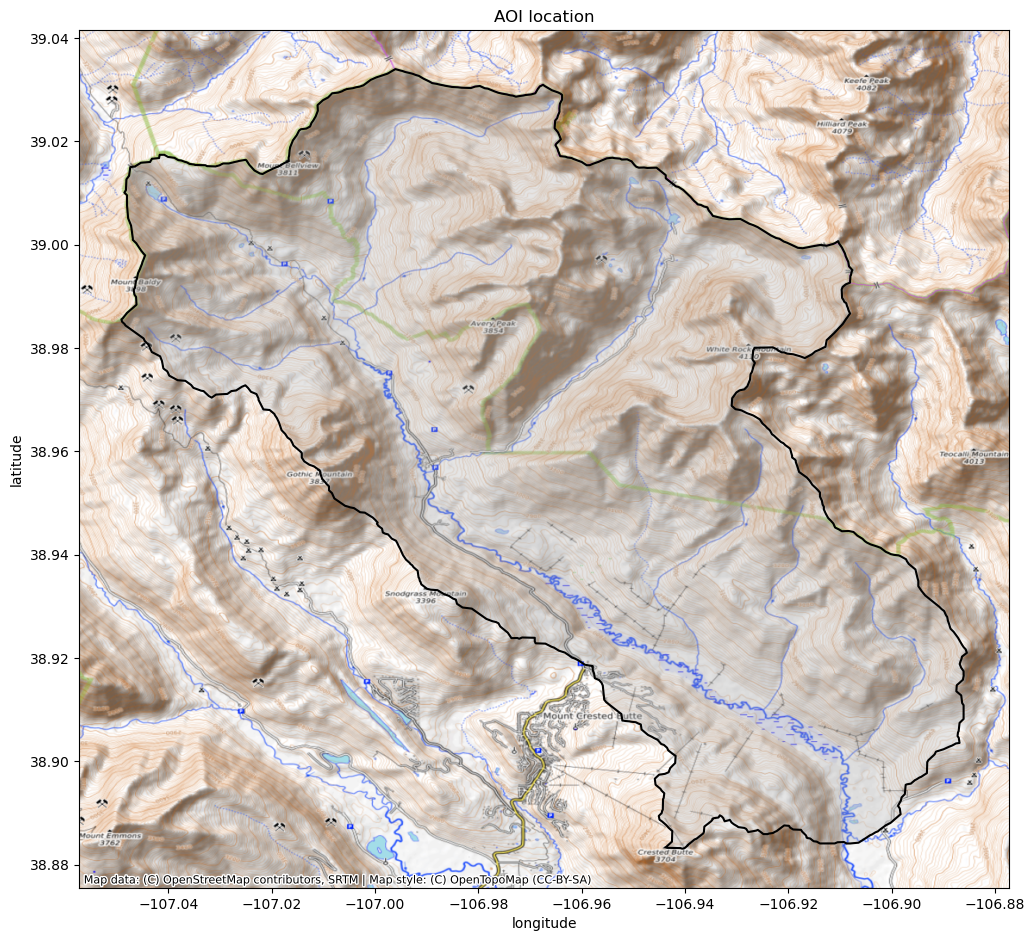

In [13]:
# Plot aoi
fig, ax = plt.subplots(figsize=(12,12))
# Plot aoi
area_gdf.plot(ax=ax,
              color='darkgrey',
              alpha=0.3)
area_gdf.boundary.plot(ax=ax,
                       color='k')

cx.add_basemap(ax=ax, crs=area_gdf.crs.to_string(), source=cx.providers.OpenTopoMap);
ax.set_xlabel('longitude');
ax.set_ylabel('latitude');
ax.set_title('AOI location');

Now, we need to set a date range for the snow depth time series. By default, this date range will start at the previous August 1, since the first Sentinel-1 acquisition needs to be snow-free. This can be changed if a different snow-free start date is more appropriate. 

In [ ]:
# this will generate a tuple of dates from the previous August 1st to this date
dates = get_input_dates('2021-07-31') # run on all S1 images from 2020-08-01 through 2021-07-31

We can now run spicy-snow with the retrieve_snow_depth function. By default, spicy-snow uses parameters optimized to ASO lidar snow depths from various sites in the western US.

If you don't have your Earthdata login information in a .netrc file in your home directory, you will be prompted for that information after running the cell. 

WARNING: this processing can use signficant memory, especially for a larger aoi/longer date range. This example aoi is ~125 square km and uses ~20G of RAM to process a full year. 

In [ ]:
# define output directory and file name
out_nc = Path(f'.data/sd_{dates[0]}_{dates[1]}.nc').expanduser()

spicy_ds = retrieve_snow_depth(area = area, dates = dates, 
                               work_dir = Path('/tmp/er_test/').expanduser(), 
                               job_name = f'sd_{dates[0]}_{dates[1]}',
                               existing_job_name = f'sd_{dates[0]}_{dates[1]}',
                               debug=False,
                               outfp=out_nc)